In [36]:
import math

expression_file_content = [line.split("\t") for line in open("../gold_standard_sentences/expression.tsv")]
expression_headers = expression_file_content[0]
expression_data = expression_file_content[1:]
expression_data = [row for row in expression_data if row[2]]

In [37]:
kinaseact_file_content = [line.split("\t") for line in open("../gold_standard_sentences/kinase_activity.tsv")]
kinaseact_headers = kinaseact_file_content[0]
kinaseact_data = kinaseact_file_content[1:]
kinaseact_data = [row for row in kinaseact_data if row[2]]

In [38]:
cleaned_expression_data = []
for row in expression_data:
    cleaned_expression_data.append([*row[0:3], "c_elegans" if row[5] != "" else "mixed" if row[6] != "" else "other", "positive" if row[22] != "" else "negative" if row[23] != "" else "both" if row[24] != "" else "neutral", 0 if row[14] != "" else 1 if row[15] != "" else 2 if row[16] != "" else 3 if row[17] != "" else 4 if row[18] != "" else 5 if row[19] != "" else 6 if row[20] != "" else 7, ])

cleaned_kinaseact_data = []
for row in kinaseact_data:
    cleaned_kinaseact_data.append([*row[0:3], "c_elegans" if row[5] != "" else "mixed" if row[6] != "" else "other" if row[7] != "" else "no_species", "positive" if row[22] != "" else "negative" if row[23] != "" else "both" if row[24] != "" else "neutral", 0 if row[14] != "" else 1 if row[15] != "" else 2 if row[16] != "" else 3 if row[17] != "" else 4 if row[18] != "" else 5 if row[19] != "" else 6 if row[20] != "" else 7])

cleaned_expression_data_orig = cleaned_expression_data[:]
cleaned_kinaseact_data_orig = cleaned_kinaseact_data[:]

cleaned_headers = ["pmid", "wb_paper_id", "sentence", "species", "result_type", "class", "location_in_paper"]


In [39]:
from sentence_classification.preprocess import clean_sentences_with_papid, read_sentences_from_file_with_papid
from random import shuffle

neg_sent_otherexpr = read_sentences_from_file_with_papid("../extracted_sentences/neg_sentences_otherexpr.txt")
neg_sent_otherexpr_cleaned = clean_sentences_with_papid(neg_sent_otherexpr)
shuffle(neg_sent_otherexpr_cleaned)



cleaned_expression_data.extend(["", "WBPaper" + row[0], row[1], "", "", 8] for row in neg_sent_otherexpr_cleaned[0:500])

neg_sent_kineaseact = read_sentences_from_file_with_papid("../extracted_sentences/neg_sentences_kinase_activity.txt")
neg_sent_kineaseact_cleaned = clean_sentences_with_papid(neg_sent_kineaseact)
shuffle(neg_sent_kineaseact_cleaned)

cleaned_kinaseact_data.extend(["", "WBPaper" + row[0], row[1], "", "", 8] for row in neg_sent_kineaseact_cleaned[0:500])

In [40]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [41]:
corpus_expr = embedder.encode([row[2] for row in cleaned_expression_data], convert_to_tensor=True)
corpus_kinaseact = embedder.encode([row[2] for row in cleaned_kinaseact_data], convert_to_tensor=True)

In [42]:
import umap

umap_reducer = umap.UMAP(metric='cosine')
corpus_expr_2d = umap_reducer.fit_transform(corpus_expr)
corpus_kinaseact_2d = umap_reducer.fit_transform(corpus_kinaseact)

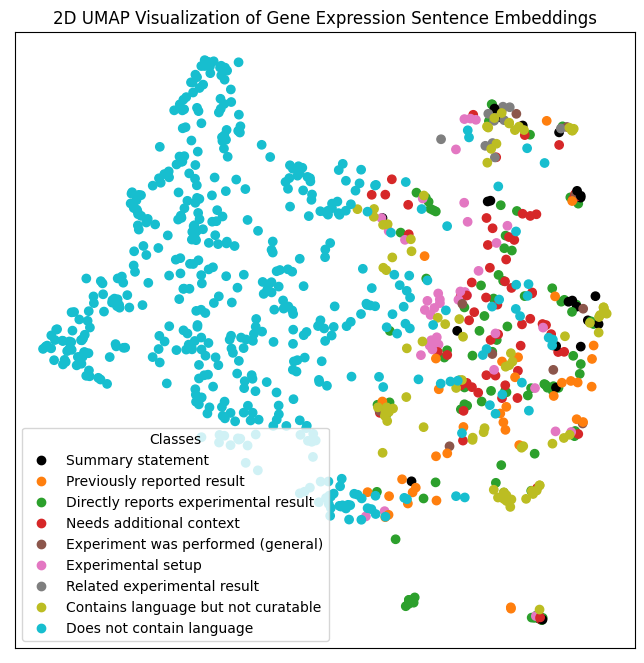

In [43]:
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt

colors = ListedColormap(['black','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey','tab:olive','tab:cyan'])
values = [row[5] for row in cleaned_expression_data]
classes = ['Summary statement', 'Previously reported result', 'Directly reports experimental result', 'Needs additional context', 'Experiment was performed (general)', 'Experimental setup', 'Related experimental result', 'Contains language but not curatable', 'Does not contain language']
fig, ax = plt.subplots(figsize=(8,8))
scatter = ax.scatter(x=list(corpus_expr_2d[:,0]), y=list(corpus_expr_2d[:,1]), c=values, cmap=colors)
plt.xticks([])
plt.yticks([])
plt.title("2D UMAP Visualization of Gene Expression Sentence Embeddings")
legend = ax.legend(handles=scatter.legend_elements()[0], loc="lower left", title="Classes", labels=classes)

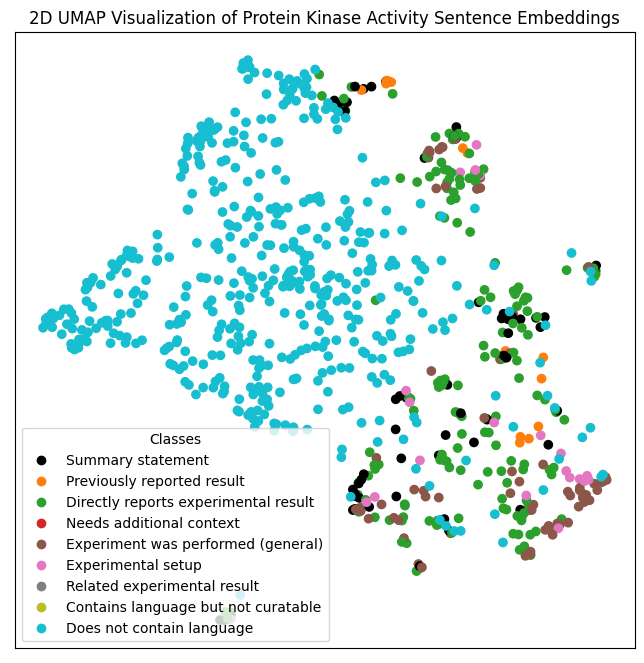

In [44]:
values = [row[5] for row in cleaned_kinaseact_data]
fig, ax = plt.subplots(figsize=(8, 8))
plt.xticks([])
plt.yticks([])
plt.title("2D UMAP Visualization of Protein Kinase Activity Sentence Embeddings")
ax.scatter(x=list(corpus_kinaseact_2d[:,0]), y=list(corpus_kinaseact_2d[:,1]), c=values, cmap=colors)
legend = ax.legend(handles=scatter.legend_elements()[0], loc="lower left", title="Classes", labels=classes)

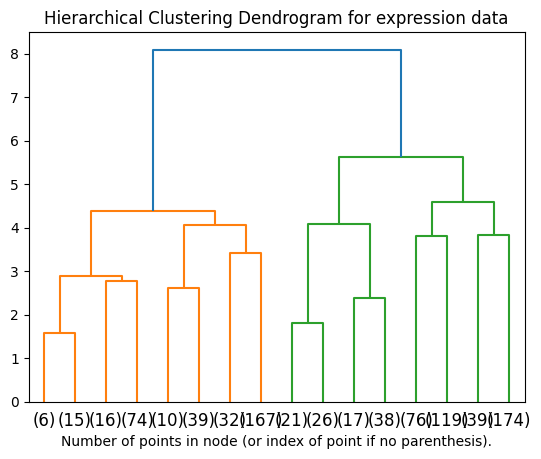

In [45]:
from sentence_classification.clustering import plot_dendrogram
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering

X_expr = corpus_expr

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0.2, n_clusters=None)

model_expr = model.fit(X_expr)
plt.title("Hierarchical Clustering Dendrogram for expression data")
# plot the top three levels of the dendrogram
plot_dendrogram(model_expr, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

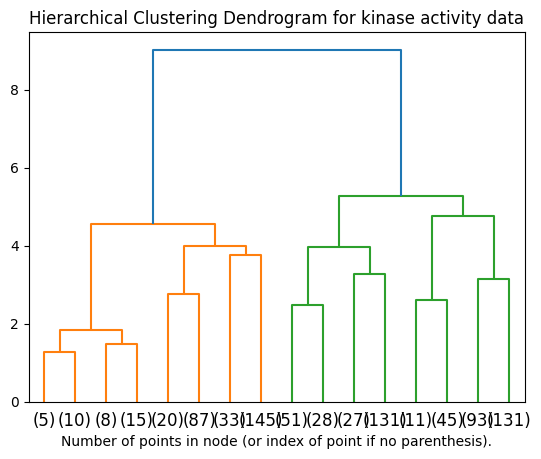

In [46]:
X_kinaseact = corpus_kinaseact

model_kinaseact = model.fit(X_kinaseact)
plt.title("Hierarchical Clustering Dendrogram for kinase activity data")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

# precision and recall using clustering with n_clusters = 2

In [47]:
model_fixed = AgglomerativeClustering(n_clusters=2)
model_fixed_expr = model_fixed.fit(X_expr)
model_fixed_kinaseact = model_fixed.fit(X_kinaseact)
tp_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 1 and cleaned_expression_data[index][5] == 2])
tn_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 0 and cleaned_expression_data[index][5] != 2])
fp_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 1 and cleaned_expression_data[index][5] != 2])
fn_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 0 and cleaned_expression_data[index][5] == 2])
precision_curatable_only_expr = tp_expr / (tp_expr + fp_expr)
recall_curatable_only_expr = tp_expr / (tp_expr + fn_expr)

tp_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 1 and cleaned_kinaseact_data[index][5] == 2])
tn_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 0 and cleaned_kinaseact_data[index][5] != 2])
fp_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 1 and cleaned_kinaseact_data[index][5] != 2])
fn_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 0 and cleaned_kinaseact_data[index][5] == 2])
precision_curatable_only_kinaseact = tp_kinaseact / (tp_kinaseact + fp_kinaseact)
recall_curatable_only_kinaseact = tp_kinaseact / (tp_kinaseact + fn_kinaseact)

tp_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 1 and cleaned_expression_data[index][5] != 8])
tn_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 0 and cleaned_expression_data[index][5] == 8])
fp_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 1 and cleaned_expression_data[index][5] == 8])
fn_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 0 and cleaned_expression_data[index][5] != 8])
precision_any_class_expr = tp_expr / (tp_expr + fp_expr)
recall_any_class_expr = tp_expr / (tp_expr + fn_expr)

tp_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 1 and cleaned_kinaseact_data[index][5] != 8])
tn_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 0 and cleaned_kinaseact_data[index][5] == 8])
fp_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 1 and cleaned_kinaseact_data[index][5] == 8])
fn_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 0 and cleaned_kinaseact_data[index][5] != 8])
precision_any_class_kinaseact = tp_kinaseact / (tp_kinaseact + fp_kinaseact)
recall_any_class_kinaseact = tp_kinaseact / (tp_kinaseact + fn_kinaseact)

tp_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 1 and cleaned_expression_data[index][5] < 7])
tn_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 0 and cleaned_expression_data[index][5] > 6])
fp_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 1 and cleaned_expression_data[index][5] > 6])
fn_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 0 and cleaned_expression_data[index][5] < 7])
precision_no_language_expr = tp_expr / (tp_expr + fp_expr)
recall_no_language_expr = tp_expr / (tp_expr + fn_expr)

tp_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 1 and cleaned_kinaseact_data[index][5] < 7])
tn_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 0 and cleaned_kinaseact_data[index][5] > 6])
fp_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 1 and cleaned_kinaseact_data[index][5] > 6])
fn_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 0 and cleaned_kinaseact_data[index][5] < 7])
precision_no_language_kinaseact = tp_kinaseact / (tp_kinaseact + fp_kinaseact)
recall_no_language_kinaseact = tp_kinaseact / (tp_kinaseact + fn_kinaseact)

print("precision curatable only expression: " + str(precision_curatable_only_expr))
print("recall curatable only expression: " + str(recall_curatable_only_expr))
print("precision curatable only kinase activity: " + str(precision_curatable_only_kinaseact))
print("recall curatable only kinase activity: " + str(recall_curatable_only_kinaseact))

print("precision any class expression: " + str(precision_any_class_expr))
print("recall any class expression: " + str(recall_any_class_expr))
print("precision any class kinase activity: " + str(precision_any_class_kinaseact))
print("recall any class kinase activity: " + str(recall_any_class_kinaseact))

print("precision no language expression: " + str(precision_no_language_expr))
print("recall no language expression: " + str(recall_no_language_expr))
print("precision no language kinase activity: " + str(precision_no_language_kinaseact))
print("recall no language kinase activity: " + str(recall_no_language_kinaseact))

precision curatable only expression: 0.25696594427244585
recall curatable only expression: 0.9222222222222223
precision curatable only kinase activity: 0.4891640866873065
recall curatable only kinase activity: 0.9132947976878613
precision any class expression: 0.9721362229102167
recall any class expression: 0.8509485094850948
precision any class kinase activity: 0.9690402476780186
recall any class kinase activity: 0.9205882352941176
precision no language expression: 0.8204334365325078
recall no language expression: 0.9397163120567376
precision no language kinase activity: 0.9690402476780186
recall no language kinase activity: 0.9205882352941176


# classifiers

In [48]:
from sklearn.neural_network import MLPClassifier
import math

converted_corpus_expr = corpus_expr.numpy()
converted_corpus_kinaseact = corpus_kinaseact.numpy()
indices_expr = [i for i in range(len(corpus_expr))]
shuffle(indices_expr)
training_size_expr = math.ceil(len(corpus_expr) * 0.8)
training_indices_expr = indices_expr[0:training_size_expr]
test_indices_expr = indices_expr[training_size_expr:]
training_set_data_expr = [converted_corpus_expr[index] for index in training_indices_expr]
test_set_classes_expr = [cleaned_expression_data[index][5] for index in test_indices_expr]
indices_kinaseact = [i for i in range(len(corpus_kinaseact))]
shuffle(indices_kinaseact)
training_size_kinaseact = math.ceil(len(corpus_kinaseact) * 0.8)
training_indices_kinaseact = indices_kinaseact[0:training_size_kinaseact]
test_indices_kinaseact = indices_kinaseact[training_size_kinaseact:]
training_set_data_kinaseact = [converted_corpus_kinaseact[index] for index in training_indices_kinaseact]
test_set_classes_kinaseact = [cleaned_kinaseact_data[index][5] for index in test_indices_kinaseact]
base_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

# prediction
## multiclass

In [49]:
from sklearn.metrics import precision_recall_fscore_support as score
training_set_classes_expr = [cleaned_expression_data[index][5] for index in training_indices_expr]
test_set_data_expr = [converted_corpus_expr[index] for index in test_indices_expr]
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)
test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.         0.         0.21276596 0.15789474 0.         0.
 0.         0.         0.95192308]
recall: [0.         0.         0.76923077 0.42857143 0.         0.
 0.         0.         0.96116505]
fscore: [0.         0.         0.33333333 0.23076923 0.         0.
 0.         0.         0.95652174]
support: [  5   8  13   7   3   7   3  24 103]


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
training_set_classes_kinaseact = [cleaned_kinaseact_data[index][5] for index in training_indices_kinaseact]
test_set_data_kinaseact = [converted_corpus_kinaseact[index] for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)
test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.         0.         0.48571429 0.25       0.         0.9893617 ]
recall: [0.         0.         1.         0.07692308 0.         0.96875   ]
fscore: [0.         0.         0.65384615 0.11764706 0.         0.97894737]
support: [16  4 34 13  5 96]


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## binary
### all classes of gold standard sentences considered positive

In [51]:
training_set_classes_expr = [1 if cleaned_expression_data[index][5] != 8 else 0 for index in training_indices_expr]
test_set_classes_expr = [1 if cleaned_expression_data[index][5] != 8 else 0 for index in test_indices_expr]
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)

test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.98019802 0.94444444]
recall: [0.96116505 0.97142857]
fscore: [0.97058824 0.95774648]
support: [103  70]


In [52]:
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr, average='binary')
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.9444444444444444
recall: 0.9714285714285714
fscore: 0.9577464788732395
support: None


In [53]:
training_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][5] != 8 else 0 for index in training_indices_kinaseact]
test_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][5] != 8 else 0 for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)

test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [1.         0.98630137]
recall: [0.98958333 1.        ]
fscore: [0.9947644  0.99310345]
support: [96 72]


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [54]:
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact, average="binary")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.9863013698630136
recall: 1.0
fscore: 0.993103448275862
support: None


### all classes but positive for language - negative for curation and negative sentences

In [55]:
training_set_classes_expr = [1 if cleaned_expression_data[index][5] < 7 else 0 for index in training_indices_expr]
test_set_classes_expr = [1 if cleaned_expression_data[index][5] < 7 else 0 for index in test_indices_expr]
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)

test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.96       0.85416667]
recall: [0.94488189 0.89130435]
fscore: [0.95238095 0.87234043]
support: [127  46]


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [56]:
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr, average="binary")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.8541666666666666
recall: 0.8913043478260869
fscore: 0.8723404255319149
support: None


In [57]:
training_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][5] < 7 else 0 for index in training_indices_kinaseact]
test_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][5] < 7 else 0 for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)

test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [1.         0.98630137]
recall: [0.98958333 1.        ]
fscore: [0.9947644  0.99310345]
support: [96 72]


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [58]:
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact, average="weighted")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.9941291585127201
recall: 0.9940476190476191
fscore: 0.9940525623500891
support: None


### only directly reports experimental results as positive

In [59]:
training_set_classes_expr = [1 if cleaned_expression_data[index][5] == 2 else 0 for index in training_indices_expr]
test_set_classes_expr = [1 if cleaned_expression_data[index][5] == 2 else 0 for index in test_indices_expr]
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)

test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.97435897 0.52941176]
recall: [0.95       0.69230769]
fscore: [0.96202532 0.6       ]
support: [160  13]


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [60]:
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr, average="binary")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.5294117647058824
recall: 0.6923076923076923
fscore: 0.5999999999999999
support: None


In [61]:
training_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][5] == 2 else 0 for index in training_indices_kinaseact]
test_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][5] == 2 else 0 for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)

test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.90151515 0.58333333]
recall: [0.8880597  0.61764706]
fscore: [0.89473684 0.6       ]
support: [134  34]


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [62]:
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact, average="binary")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.5833333333333334
recall: 0.6176470588235294
fscore: 0.6
support: None


### Directly reports experimental result + need additional context as positive

In [63]:
training_set_classes_expr = [1 if cleaned_expression_data[index][5] in [2, 3] else 0 for index in training_indices_expr]
test_set_classes_expr = [1 if cleaned_expression_data[index][5] in [2, 3] else 0 for index in test_indices_expr]
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)

test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.95454545 0.68421053]
recall: [0.96078431 0.65      ]
fscore: [0.95765472 0.66666667]
support: [153  20]


In [64]:
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr, average="binary")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.6842105263157895
recall: 0.65
fscore: 0.6666666666666667
support: None


In [65]:
training_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][5] == 2 else 0 for index in training_indices_kinaseact]
test_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][5] == 2 else 0 for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)

test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.90151515 0.58333333]
recall: [0.8880597  0.61764706]
fscore: [0.89473684 0.6       ]
support: [134  34]


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [66]:
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact, average="binary")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.5833333333333334
recall: 0.6176470588235294
fscore: 0.6
support: None


# Feature analysis for positive sentences

## expression

(0.0, 100.0)

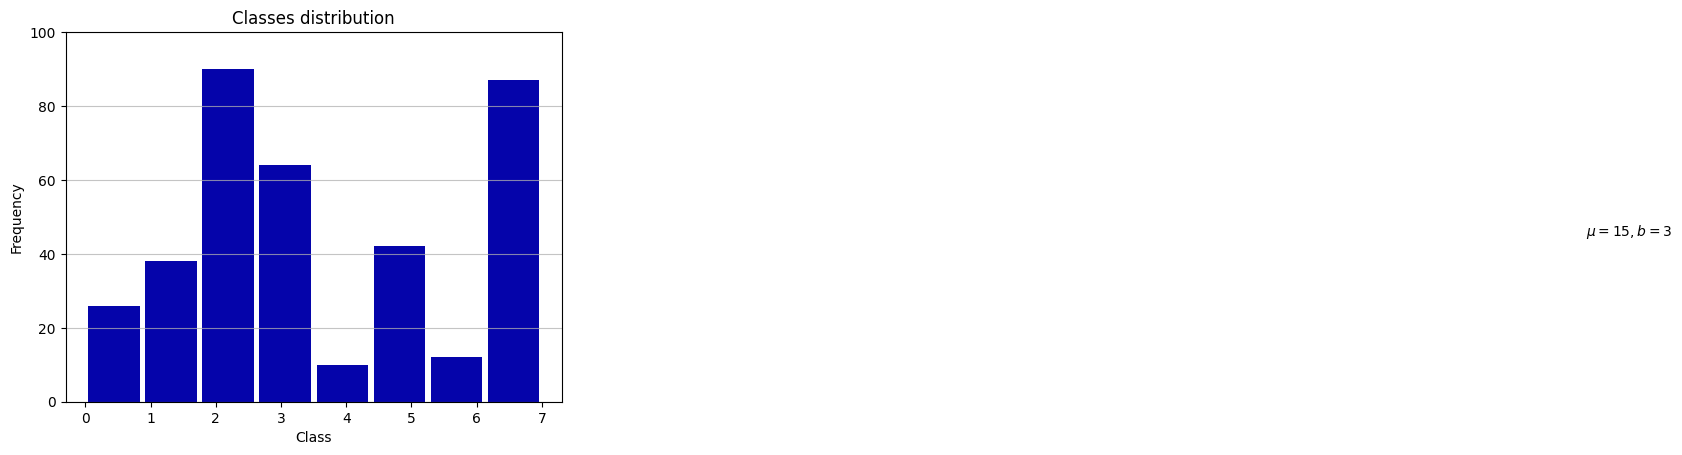

In [67]:
import matplotlib.pyplot as plt
import numpy as np

n, bins, patches = plt.hist(x=[r[5] for r in cleaned_expression_data_orig], bins=8, color='#0504aa',
                            alpha=1, rwidth=0.9)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Classes distribution')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [68]:
[expression_data[i][8] for i, r in enumerate(cleaned_expression_data_orig) if r[5] != 2]

['Abstract',
 'Discussion',
 'Discussion',
 'Discussion',
 'Discussion',
 'Abstract',
 'Introduction',
 'Discussion Paragraph title',
 'Introduction',
 'Discussion',
 'Discussion',
 'Discussion',
 'Results',
 'Supplemental figure legends',
 'Supplemental figure legends',
 'Supplemental figure legends',
 'Supplemental figure legends',
 'Supplemental figure legends',
 'Supplemental figure legends',
 'Supplemental figure legends',
 'Supplemental figure legends',
 'Figure legend',
 'Figure legend',
 'Figure legend',
 'Results',
 'Results',
 'Results',
 'Results',
 'Figure legend',
 'Results',
 'Figure legend',
 'Results',
 'Discussion',
 'Results',
 'Results',
 'Results',
 'Results',
 'Results',
 'Results',
 'Figure 3',
 'Figure 3',
 'Results',
 'Results',
 'Results',
 'Results',
 'Introduction',
 'Figure 2',
 'Figure 3',
 'Figure legend',
 'Supplemental figure legends',
 'Supplemental figure legends',
 'Supplemental figure legends',
 'Figure 2',
 'Supplemental figure legends',
 'Supplemen

# kinase act

(0.0, 180.0)

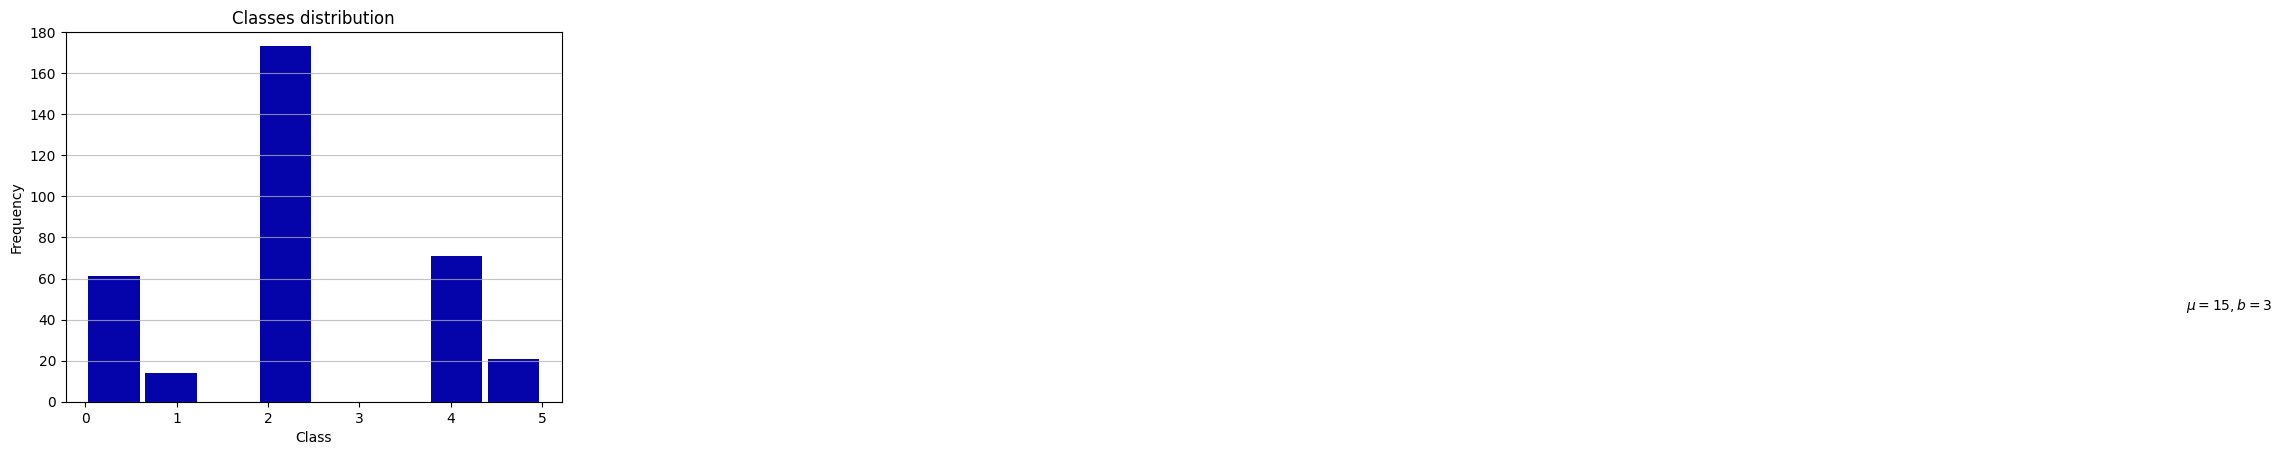

In [69]:
n, bins, patches = plt.hist(x=[r[5] for r in cleaned_kinaseact_data_orig], bins=8, color='#0504aa',
                            alpha=1, rwidth=0.9)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Classes distribution')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [70]:
expression_headers

['PMID',
 'WB Paper ID',
 'Sentence',
 'Computer curatable',
 'Human curatable',
 'C elegans only',
 'Mixed species (C. elegans + other species)',
 'Other species only',
 'Paper Section',
 'Refers to figure and/or table',
 'Publication year',
 'Journal',
 'Location: section heading',
 'Location: figure title',
 'Type of statement: summary statement',
 'Type of statement: previously reported result',
 'Type of statement: directly reports experimental result - either positive or negative, i.e. expressed in, not expressed  in',
 'Type of statement: directly reports experimental result but needs additional context',
 'Type of statement: experiment was performed - general',
 'Type of statement: experimental set up',
 'Type of statement: related experimental result. e.g. analysys in mutants that hint to a WT experiment. ',
 'Type of statement: contains language but negative for curation',
 'Type of result: positive result',
 'Type of result: negative result',
 'Type of result: positive + neg